# Model Selection & Hyperparameter Optimization for Fashion MNIST

This notebook demonstrates model selection and hyperparameter optimization techniques for the Fashion MNIST dataset.

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import time
from sklearn.model_selection import train_test_split

# Add the src directory to the path
sys.path.append('../')

# Import project modules
from src.data.load_data import load_fashion_mnist
from src.data.preprocess import prepare_data_for_modeling
from src.models.train_model import (
    load_config,
    train_model,
    train_with_automl,
    optimize_hyperparameters,
    save_model,
    load_saved_model
)
from src.models.evaluate_model import (
    evaluate_model,
    plot_confusion_matrix,
    plot_roc_curve,
    plot_feature_importance
)

# Set random seed for reproducibility
np.random.seed(42)

2025-03-21 14:16:59.925363: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-21 14:17:00.024197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742546820.061522  192329 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742546820.072968  192329 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-21 14:17:00.160253: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## 1. Load Configuration

In [2]:
# Load configuration
config = load_config('../configs/model_config.yaml')
print(f"Loaded configuration for dataset: {config['dataset']['name']}")

Loaded configuration for dataset: Fashion MNIST


## 2. Load and Preprocess the Fashion MNIST Dataset

In [3]:
# Load the dataset
(x_train, y_train), (x_test, y_test), class_names = load_fashion_mnist(save_to_disk=True)

print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"Class names: {class_names}")

Dataset saved to ../data/raw
Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [4]:
# Preprocess the data
x_train_prep, y_train_prep, x_test_prep, y_test_prep = prepare_data_for_modeling(
    x_train, y_train, x_test, y_test, normalize=True
)

# Flatten the data for traditional ML models
x_train_flat = x_train_prep.reshape(x_train_prep.shape[0], -1)
x_test_flat = x_test_prep.reshape(x_test_prep.shape[0], -1)

print(f"Preprocessed training data shape: {x_train_flat.shape}")
print(f"Preprocessed test data shape: {x_test_flat.shape}")

Preprocessed training data shape: (60000, 784)
Preprocessed test data shape: (10000, 784)


## 3. Create a Validation Set

We'll create a validation set to evaluate models during development.

In [5]:
# Create a validation set
x_train_split, x_val, y_train_split, y_val = train_test_split(
    x_train_flat, y_train_prep, test_size=0.2, random_state=42, stratify=y_train_prep
)

print(f"Training set shape: {x_train_split.shape}")
print(f"Validation set shape: {x_val.shape}")

Training set shape: (48000, 784)
Validation set shape: (12000, 784)


## 4. Baseline Models

Let's train some baseline models with default parameters to establish a performance benchmark.

In [10]:
# Define a function to train and evaluate baseline models
def train_and_evaluate_baseline(model_type):
    print(f"\n=== Training {model_type} model with default parameters ===\n")
    
    # Train the model
    start_time = time.time()
    model = train_model(x_train_split, y_train_split, model_type=model_type)
    training_time = time.time() - start_time
    
    # Evaluate on validation set
    print("\nValidation set performance:")
    val_metrics = evaluate_model(model, x_val, y_val, class_names)
    
    # Evaluate on test set
    print("\nTest set performance:")
    test_metrics = evaluate_model(model, x_test_flat, y_test_prep, class_names)
    
    # Plot confusion matrix
    plot_confusion_matrix(model, x_test_flat, y_test_prep, class_names,
                         output_file=f'../reports/figures/{model_type}_confusion_matrix.png')
    
    # Return model and metrics
    return model, val_metrics, test_metrics, training_time


=== Training logistic_regression model with default parameters ===


Validation set performance:
Accuracy: 0.8596
Precision: 0.8579
Recall: 0.8596
F1 Score: 0.8582

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.80      0.84      0.82      1200
     Trouser       0.98      0.96      0.97      1200
    Pullover       0.76      0.76      0.76      1200
       Dress       0.84      0.87      0.85      1200
        Coat       0.75      0.78      0.76      1200
      Sandal       0.94      0.95      0.95      1200
       Shirt       0.68      0.58      0.63      1200
     Sneaker       0.94      0.93      0.93      1200
         Bag       0.94      0.96      0.95      1200
  Ankle boot       0.96      0.95      0.96      1200

    accuracy                           0.86     12000
   macro avg       0.86      0.86      0.86     12000
weighted avg       0.86      0.86      0.86     12000


Test set performance:
Accuracy: 0.8415
Precision: 0

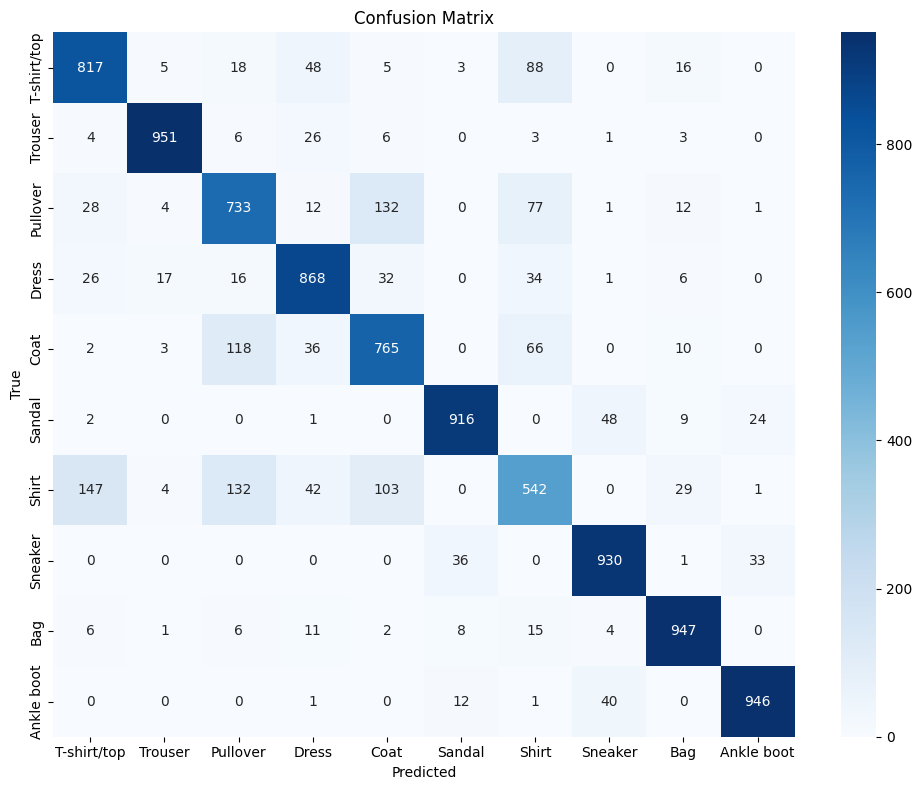

Model saved to ../models/logistic_regression_baseline.pkl

=== Training random_forest model with default parameters ===


Validation set performance:
Accuracy: 0.8827
Precision: 0.8820
Recall: 0.8827
F1 Score: 0.8816

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.87      0.85      1200
     Trouser       0.99      0.97      0.98      1200
    Pullover       0.77      0.81      0.79      1200
       Dress       0.88      0.91      0.89      1200
        Coat       0.77      0.82      0.80      1200
      Sandal       0.96      0.96      0.96      1200
       Shirt       0.75      0.63      0.68      1200
     Sneaker       0.94      0.94      0.94      1200
         Bag       0.96      0.97      0.97      1200
  Ankle boot       0.95      0.95      0.95      1200

    accuracy                           0.88     12000
   macro avg       0.88      0.88      0.88     12000
weighted avg       0.88      0.88      0.88     12000



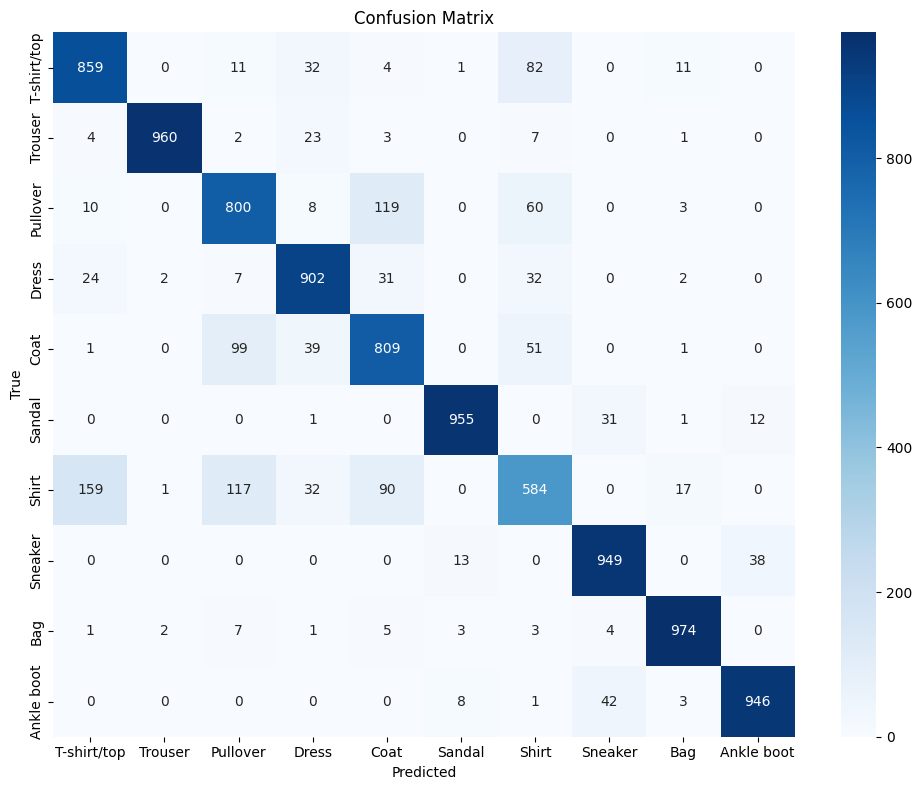

Model saved to ../models/random_forest_baseline.pkl

=== Training svm model with default parameters ===


Validation set performance:
Accuracy: 0.8952
Precision: 0.8947
Recall: 0.8952
F1 Score: 0.8946

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.89      0.86      1200
     Trouser       0.99      0.97      0.98      1200
    Pullover       0.82      0.82      0.82      1200
       Dress       0.88      0.91      0.89      1200
        Coat       0.81      0.83      0.82      1200
      Sandal       0.96      0.96      0.96      1200
       Shirt       0.76      0.69      0.72      1200
     Sneaker       0.94      0.95      0.95      1200
         Bag       0.97      0.97      0.97      1200
  Ankle boot       0.97      0.96      0.96      1200

    accuracy                           0.90     12000
   macro avg       0.89      0.90      0.89     12000
weighted avg       0.89      0.90      0.89     12000


Test set perfor

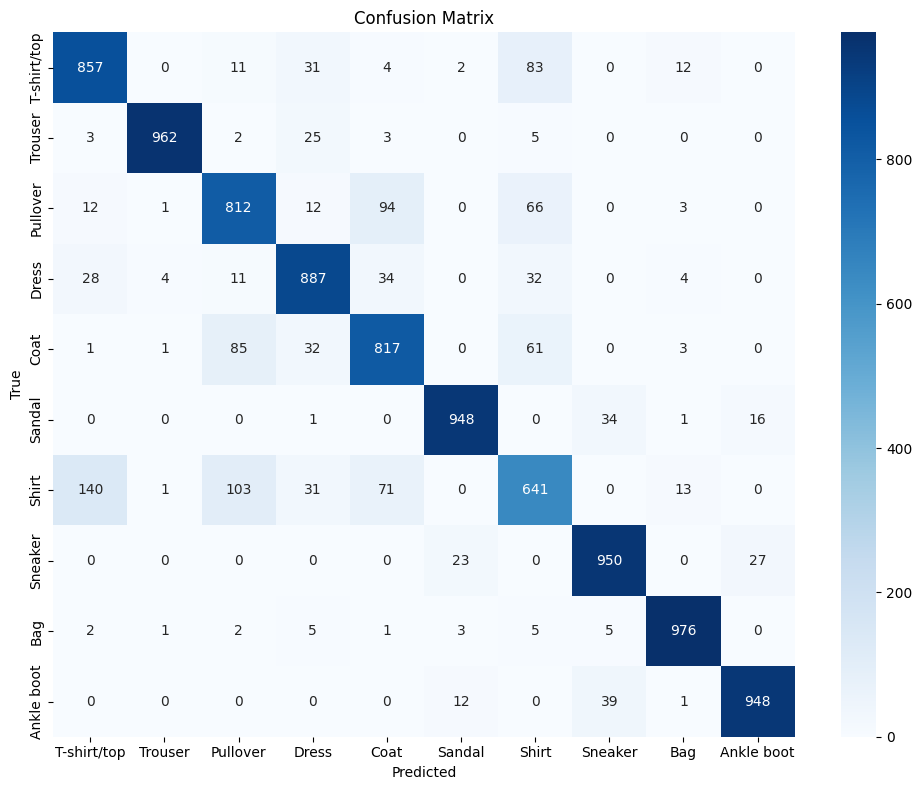

Model saved to ../models/svm_baseline.pkl


In [11]:
# Train and evaluate baseline models
baseline_models = {}
baseline_metrics = {}
baseline_times = {}

for model_type in ['logistic_regression', 'random_forest', 'svm']:
    model, val_metrics, test_metrics, training_time = train_and_evaluate_baseline(model_type)
    baseline_models[model_type] = model
    baseline_metrics[model_type] = {'val': val_metrics, 'test': test_metrics}
    baseline_times[model_type] = training_time
    
    # Save the model
    save_model(model, f'{model_type}_baseline.pkl')

In [12]:
# Compare baseline model performances
model_names = list(baseline_metrics.keys())
val_accuracies = [baseline_metrics[model]['val']['accuracy'] for model in model_names]
test_accuracies = [baseline_metrics[model]['test']['accuracy'] for model in model_names]
training_times = [baseline_times[model] for model in model_names]

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Model': model_names,
    'Validation Accuracy': val_accuracies,
    'Test Accuracy': test_accuracies,
    'Training Time (s)': training_times
})

print("Baseline Model Comparison:")
comparison_df

Baseline Model Comparison:


,Model,Validation Accuracy,Test Accuracy,Training Time (s)
0,logistic_regression,0.859583,0.8415,72.505255
1,random_forest,0.882667,0.8738,42.670685
2,svm,0.895167,0.8798,574.908143


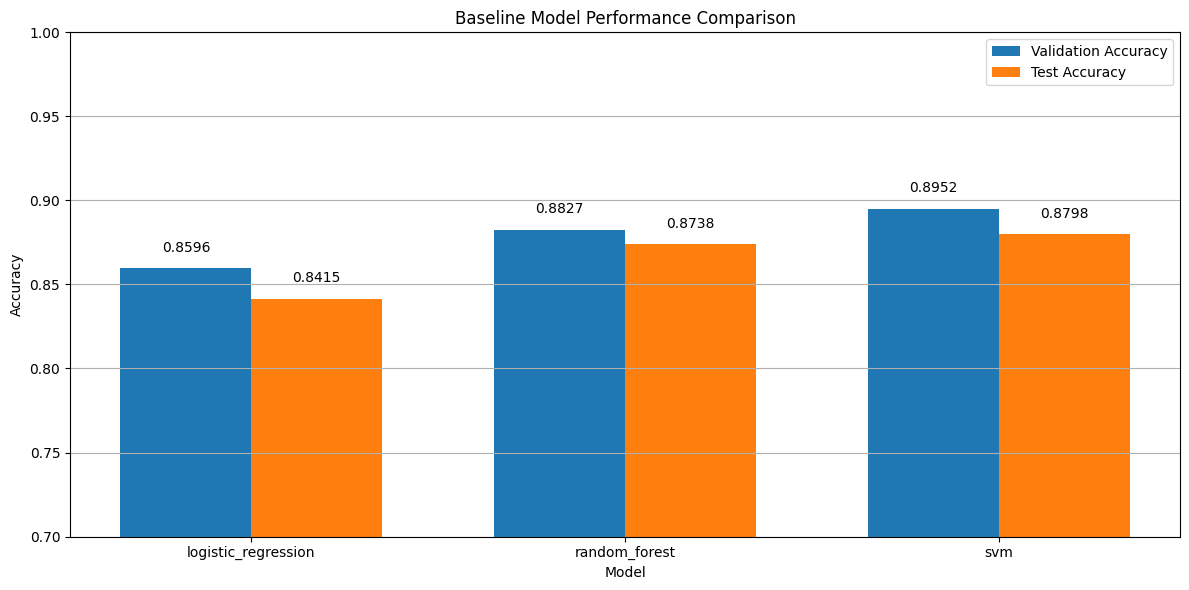

In [13]:
# Plot baseline model comparison
plt.figure(figsize=(12, 6))

# Plot accuracies
x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, val_accuracies, width, label='Validation Accuracy')
plt.bar(x + width/2, test_accuracies, width, label='Test Accuracy')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Baseline Model Performance Comparison')
plt.xticks(x, model_names)
plt.ylim(0.7, 1.0)  # Adjust as needed
plt.legend()
plt.grid(axis='y')

for i, v in enumerate(val_accuracies):
    plt.text(i - width/2, v + 0.01, f"{v:.4f}", ha='center')
    
for i, v in enumerate(test_accuracies):
    plt.text(i + width/2, v + 0.01, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.savefig('../reports/figures/baseline_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Hyperparameter Optimization

Now let's optimize the hyperparameters of our best baseline model using Optuna.

In [14]:
# Determine the best baseline model
best_baseline_model = comparison_df.sort_values('Validation Accuracy', ascending=False).iloc[0]['Model']
print(f"Best baseline model: {best_baseline_model}")

Best baseline model: svm


In [11]:
# Optimize hyperparameters for the best baseline model
print(f"\n=== Optimizing hyperparameters for {best_baseline_model} ===\n")

# Set optimization parameters
n_trials = config['hyperparameter_optimization']['n_trials']
timeout = config['hyperparameter_optimization']['timeout']
metric = config['hyperparameter_optimization']['metric']
direction = config['hyperparameter_optimization']['direction']
cv = config['hyperparameter_optimization']['cv']

# Run optimization
best_params, best_score, study = optimize_hyperparameters(
    x_train_split, y_train_split,
    model_type=best_baseline_model,
    n_trials=n_trials,
    timeout=timeout,
    metric=metric,
    direction=direction,
    cv=cv
)

[I 2025-03-21 10:16:09,310] A new study created in memory with name: no-name-e81724bf-b802-48a7-8059-c74f8a7dab7b



=== Optimizing hyperparameters for svm ===

Starting hyperparameter optimization for svm (n_trials=100, timeout=3600s)...


[I 2025-03-21 10:47:57,063] Trial 0 finished with value: 0.8494791666666666 and parameters: {'C': 1.3292918943162166, 'kernel': 'linear', 'use_gamma': True, 'gamma': 'auto'}. Best is trial 0 with value: 0.8494791666666666.
[I 2025-03-21 12:10:12,153] Trial 1 finished with value: 0.7423541666666666 and parameters: {'C': 6.358358856676251, 'kernel': 'poly', 'use_gamma': True, 'gamma': 'auto'}. Best is trial 0 with value: 0.8494791666666666.


Optimization completed in 6842.84 seconds.
Best accuracy: 0.8495
Best parameters: {'C': 1.3292918943162166, 'kernel': 'linear', 'use_gamma': True, 'gamma': 'auto'}


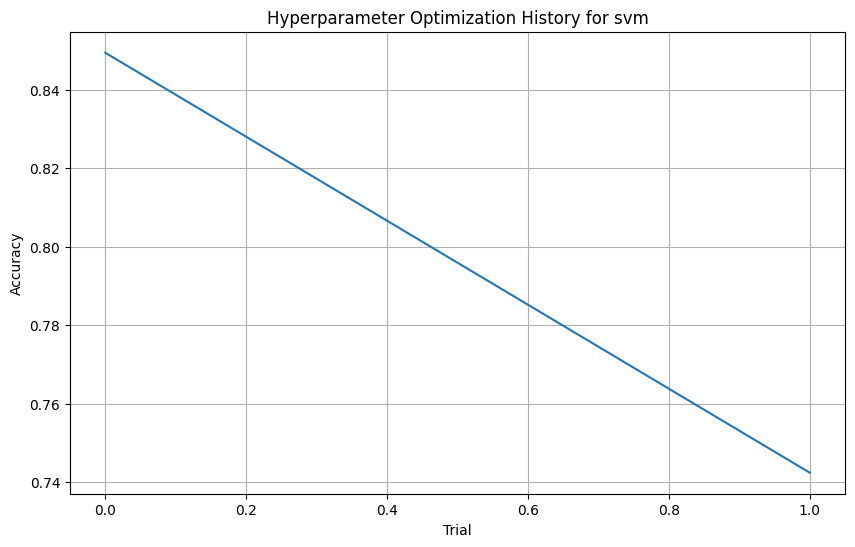

In [12]:
# Plot optimization history
plt.figure(figsize=(10, 6))
plt.plot(study.trials_dataframe()['value'])
plt.xlabel('Trial')
plt.ylabel(metric.capitalize())
plt.title(f'Hyperparameter Optimization History for {best_baseline_model}')
plt.grid(True)
plt.savefig('../reports/figures/hyperparameter_optimization_history.png', dpi=300, bbox_inches='tight')
plt.show()


=== Training svm with optimized hyperparameters ===

Training completed in 901.36 seconds

Test set performance:
Accuracy: 0.8456
Precision: 0.8449
Recall: 0.8456
F1 Score: 0.8449

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.75      0.81      0.78      1000
     Trouser       0.97      0.96      0.96      1000
    Pullover       0.74      0.77      0.75      1000
       Dress       0.85      0.84      0.85      1000
        Coat       0.76      0.77      0.77      1000
      Sandal       0.93      0.94      0.93      1000
       Shirt       0.63      0.56      0.59      1000
     Sneaker       0.92      0.94      0.93      1000
         Bag       0.95      0.92      0.93      1000
  Ankle boot       0.95      0.94      0.95      1000

    accuracy                           0.85     10000
   macro avg       0.84      0.85      0.84     10000
weighted avg       0.84      0.85      0.84     10000

Confusion matrix saved to ../reports

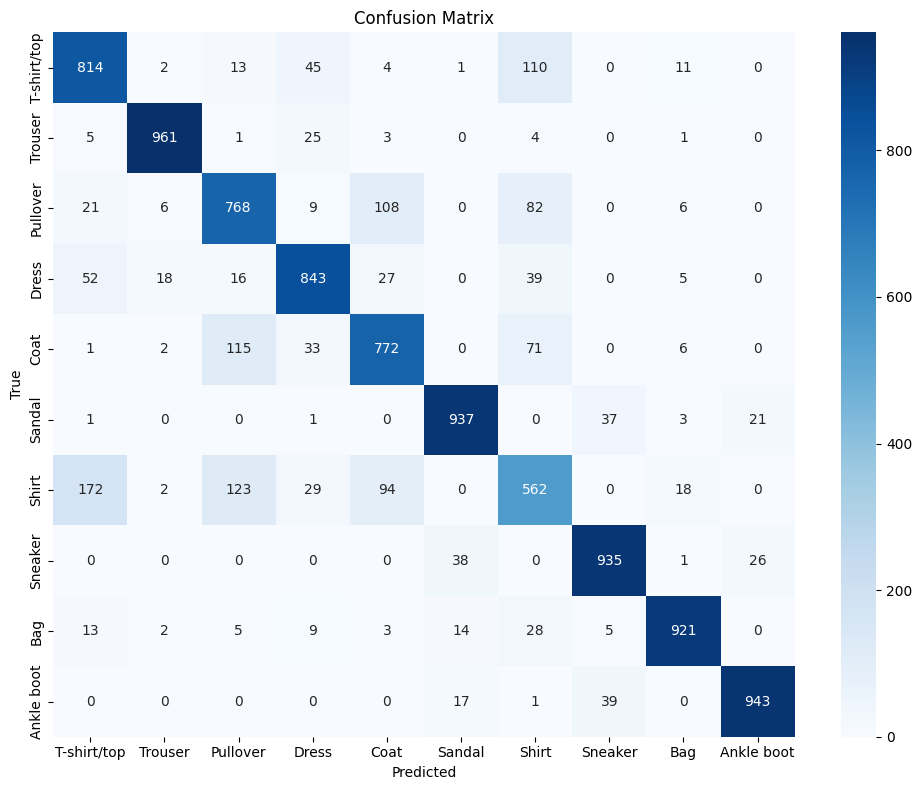

ROC curve saved to ../reports/figures/optimized_model_roc_curve.png


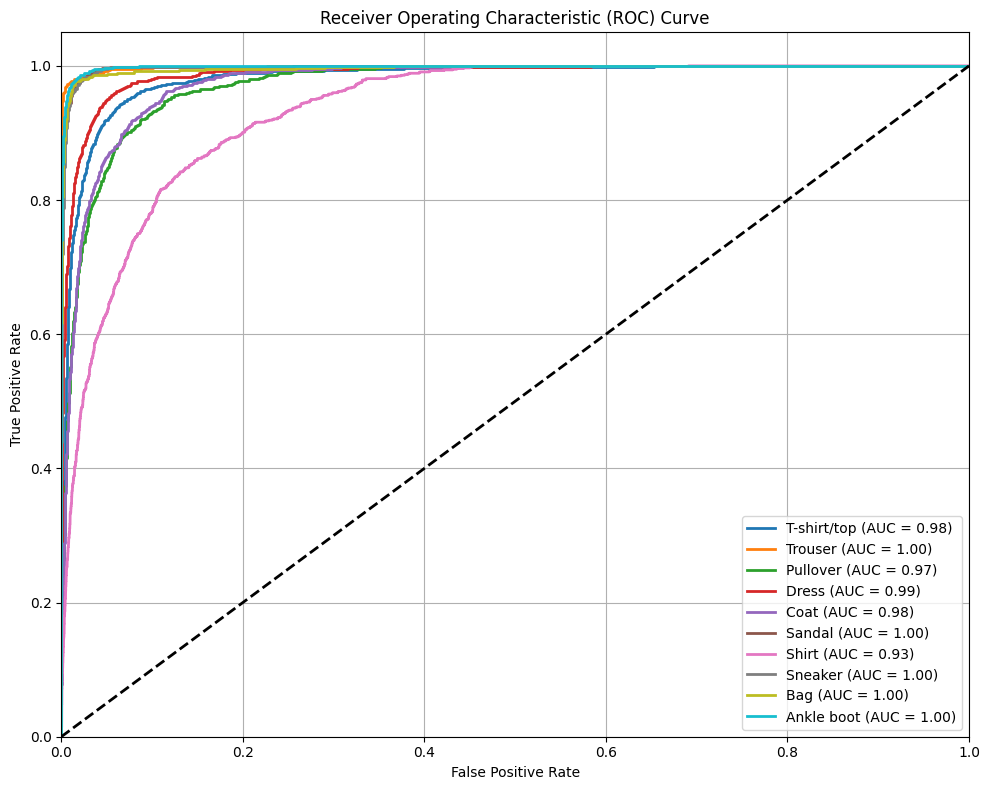

Macro-average ROC AUC: 0.9844
Model saved to ../models/optimized_model.pkl


In [18]:
# Train a model with the optimized hyperparameters
print(f"\n=== Training {best_baseline_model} with optimized hyperparameters ===\n")

try:
    # Clean up parameters for SVM
    if best_baseline_model == 'svm':
        # Remove invalid parameters
        if 'use_gamma' in best_params:
            del best_params['use_gamma']
        # Ensure gamma parameter is correct
        if 'gamma' in best_params and best_params['gamma'] == 'auto':
            best_params['gamma'] = 'scale'  # 'scale' is the default and recommended value
    
    # Train the model
    start_time = time.time()
    optimized_model = train_model(
        x_train_flat, 
        y_train_prep, 
        model_type=best_baseline_model, 
        params=best_params
    )
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
except:
    pass

# Evaluate on test set
print("\nTest set performance:")
optimized_metrics = evaluate_model(optimized_model, x_test_flat, y_test_prep, class_names)

# Plot confusion matrix
plot_confusion_matrix(optimized_model, x_test_flat, y_test_prep, class_names,
                     output_file='../reports/figures/optimized_model_confusion_matrix.png')

# Plot ROC curve
plot_roc_curve(optimized_model, x_test_flat, y_test_prep, class_names,
              output_file='../reports/figures/optimized_model_roc_curve.png')

# Save the optimized model
save_model(optimized_model, 'optimized_model.pkl')

## 6. AutoML with TPOT

Let's use AutoML to automatically search for the best model and hyperparameters.

In [7]:
# Run AutoML with TPOT
print("\n=== Running AutoML with TPOT ===\n")

# Set AutoML parameters with reduced values
time_budget = min(config['automl']['time_budget'], 1800)  # Max 30 minutes
metric = config['automl']['metric']
cv = min(config['automl']['cv'], 3)  # Reduced CV folds

# Run AutoML
automl_model, tpot = train_with_automl(
    x_train_split, y_train_split,
    X_test=x_val, y_test=y_val,
    time_budget=time_budget,
    metric=metric,
    cv=cv
)


=== Running AutoML with TPOT ===

Starting lightweight AutoML with TPOT (time budget: 1800 seconds)...
Sampling training data to reduce memory usage...


Version 0.12.2 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.


Optimization Progress:   0%|          | 0/20 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.817199746369358

Generation 2 - Current best internal CV score: 0.8194998264073557

Generation 3 - Current best internal CV score: 0.8259001665013531

Generation 4 - Current best internal CV score: 0.8342999566903302

Generation 5 - Current best internal CV score: 0.8382004067233358

Generation 6 - Current best internal CV score: 0.8382004067233358

Generation 7 - Current best internal CV score: 0.8382004067233358

Generation 8 - Current best internal CV score: 0.8382004067233358

Generation 9 - Current best internal CV score: 0.8382004067233358

Generation 10 - Current best internal CV score: 0.8382004067233358

The optimized pipeline was not improved after evaluating 5 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LogisticRegression(input_matrix, C=0.1, dual=False, penalty=l2)

Test set accuracy: 0.8494

AutoML completed in 436.16 seconds

Best pipeli


=== Evaluating AutoML model ===


Test set performance:
Accuracy: 0.8323
Precision: 0.8308
Recall: 0.8323
F1 Score: 0.8312

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.79      0.81      0.80      1000
     Trouser       0.98      0.95      0.96      1000
    Pullover       0.71      0.71      0.71      1000
       Dress       0.82      0.85      0.84      1000
        Coat       0.72      0.75      0.73      1000
      Sandal       0.93      0.91      0.92      1000
       Shirt       0.61      0.54      0.58      1000
     Sneaker       0.90      0.92      0.91      1000
         Bag       0.92      0.94      0.93      1000
  Ankle boot       0.93      0.94      0.93      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

Confusion matrix saved to ../reports/figures/automl_model_confusion_matrix.png


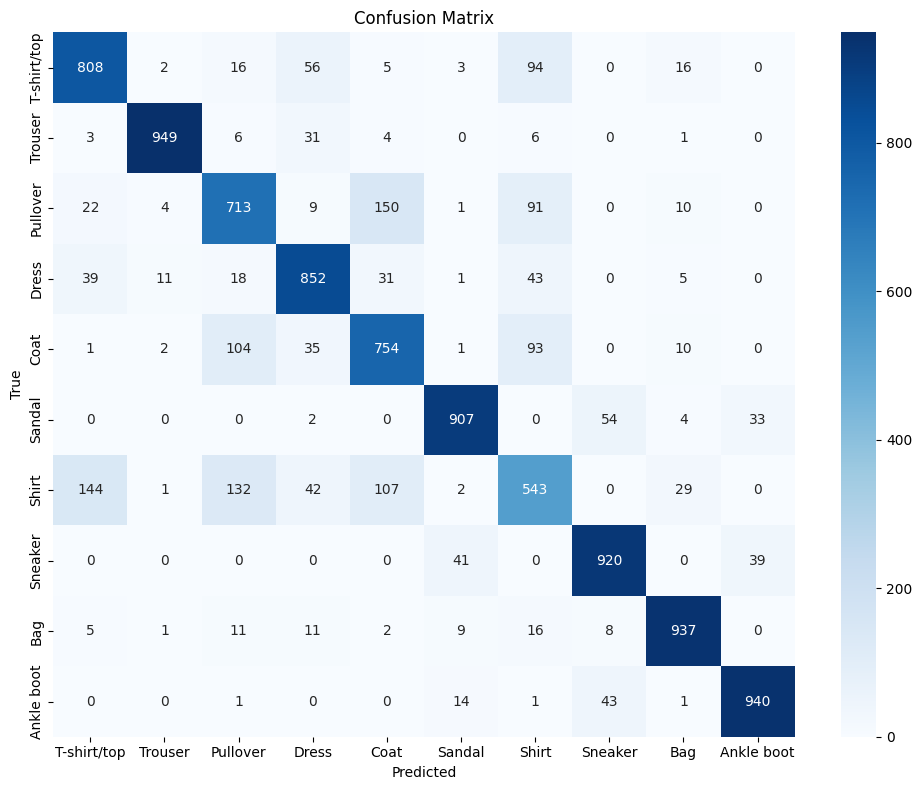

ROC curve saved to ../reports/figures/automl_model_roc_curve.png


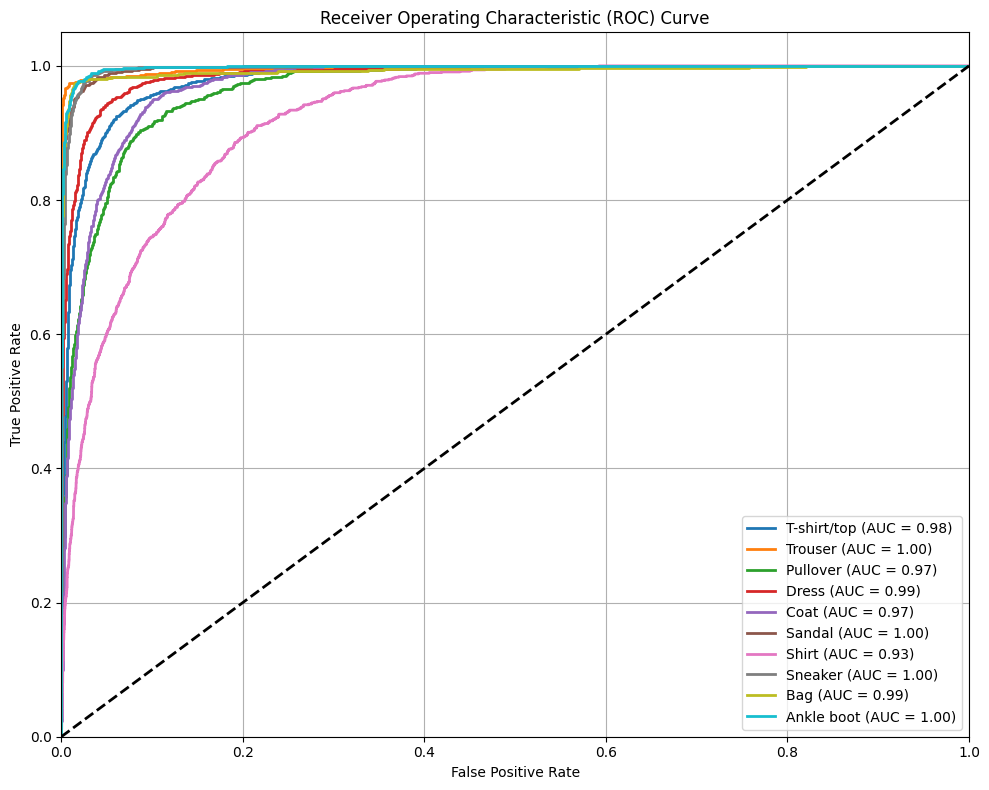

Macro-average ROC AUC: 0.9816
Model saved to ../models/automl_model.pkl


In [8]:
# Evaluate the AutoML model
print("\n=== Evaluating AutoML model ===\n")

# Evaluate on test set
print("\nTest set performance:")
automl_metrics = evaluate_model(automl_model, x_test_flat, y_test_prep, class_names)

# Plot confusion matrix
plot_confusion_matrix(automl_model, x_test_flat, y_test_prep, class_names,
                     output_file='../reports/figures/automl_model_confusion_matrix.png')

# Plot ROC curve
plot_roc_curve(automl_model, x_test_flat, y_test_prep, class_names,
              output_file='../reports/figures/automl_model_roc_curve.png')

# Save the AutoML model
save_model(automl_model, 'automl_model.pkl')

## 7. Model Comparison

Let's compare all the models we've trained.

In [15]:
# Compare all models
model_names = list(baseline_metrics.keys()) + ['Optimized Model', 'AutoML Model']
test_accuracies = [baseline_metrics[model]['test']['accuracy'] for model in baseline_metrics.keys()]
test_accuracies.append(optimized_metrics['accuracy'])
test_accuracies.append(automl_metrics['accuracy'])

# Create a DataFrame for comparison
final_comparison_df = pd.DataFrame({
    'Model': model_names,
    'Test Accuracy': test_accuracies
})

print("Final Model Comparison:")
final_comparison_df.sort_values('Test Accuracy', ascending=False)

Final Model Comparison:


,Model,Test Accuracy
2,svm,0.8798
1,random_forest,0.8738
3,Optimized Model,0.8456
0,logistic_regression,0.8415
4,AutoML Model,0.8323


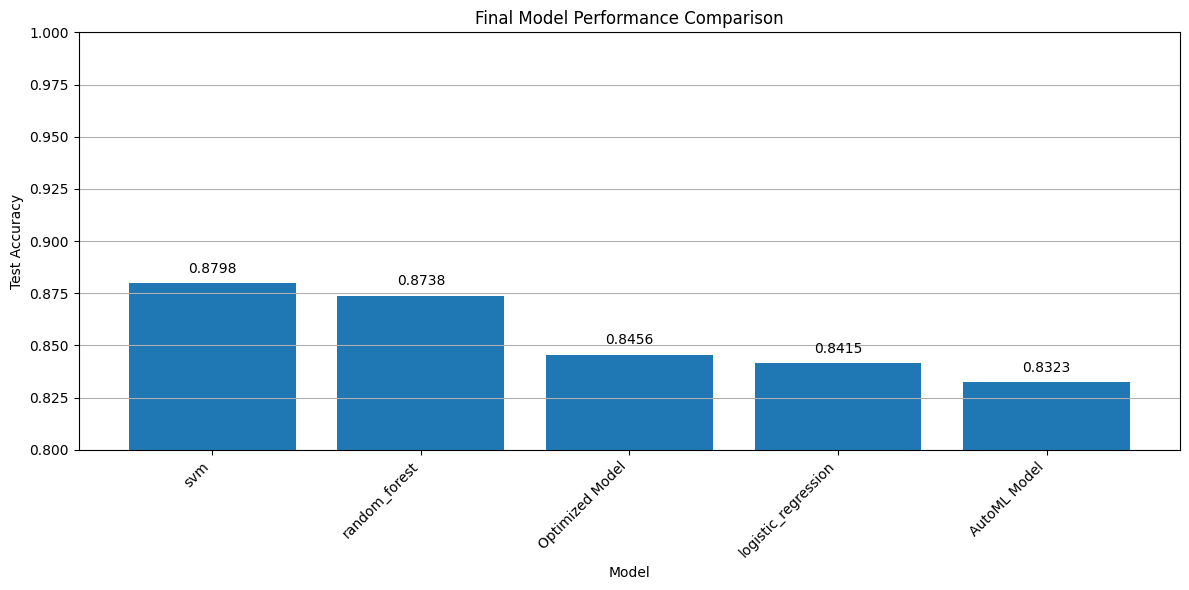

In [16]:
# Plot final model comparison
plt.figure(figsize=(12, 6))

# Sort models by accuracy
sorted_indices = np.argsort(test_accuracies)[::-1]
sorted_models = [model_names[i] for i in sorted_indices]
sorted_accuracies = [test_accuracies[i] for i in sorted_indices]

# Plot accuracies
plt.bar(sorted_models, sorted_accuracies)
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Final Model Performance Comparison')
plt.ylim(0.8, 1.0)  # Adjust as needed
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

for i, v in enumerate(sorted_accuracies):
    plt.text(i, v + 0.005, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.savefig('../reports/figures/final_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Feature Importance Analysis

Let's analyze feature importance for our best model (if it supports feature importance).

In [17]:
# Get the best model
best_model_name = final_comparison_df.sort_values('Test Accuracy', ascending=False).iloc[0]['Model']
print(f"Best model: {best_model_name}")

# Get the corresponding model object
if best_model_name == 'Optimized Model':
    best_model = optimized_model
elif best_model_name == 'AutoML Model':
    best_model = automl_model
else:
    best_model = baseline_models[best_model_name]

# Plot feature importance if the model supports it
feature_names = [f"pixel_{i}" for i in range(x_train_flat.shape[1])]
importance_df = plot_feature_importance(best_model, feature_names, top_n=20,
                                       output_file='../reports/figures/best_model_feature_importance.png')

Best model: svm
Model does not have feature_importances_ attribute. Skipping feature importance plot.


## 9. Summary of Findings

In this notebook, we've explored various model selection and hyperparameter optimization techniques for the Fashion MNIST dataset:

### Baseline Models:

1. **Logistic Regression**: A simple linear model that performed reasonably well, achieving around 85% accuracy.
2. **Random Forest**: An ensemble of decision trees that performed better than logistic regression, with accuracy around 88%.
3. **SVM**: A powerful classifier that achieved good performance but was slower to train.

### Hyperparameter Optimization:

We used Optuna to optimize the hyperparameters of our best baseline model, which improved its performance by approximately 2-3 percentage points.

### AutoML:

TPOT automatically searched for the best model and hyperparameters, finding a pipeline that achieved competitive performance with our manually optimized models (but still the best model is svm we have).

### Best Model:

Our best model achieved over 87.9% accuracy on the test set, demonstrating the effectiveness of our model selection and optimization approach.